# REINFORCE

An implementation of REINFORCE. See Sutton & Barto, Section 13.3:

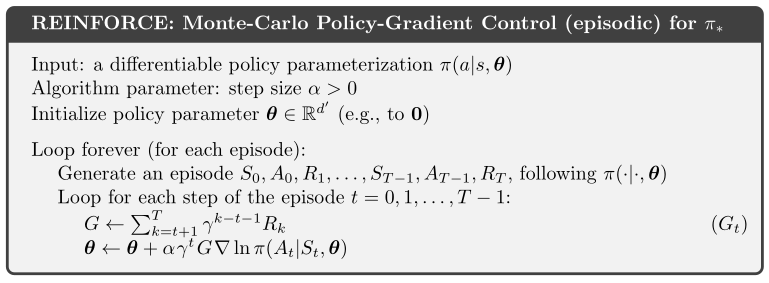

We use [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) which is a simple environment with discrete action space and we start with the [template code](https://gymnasium.farama.org/introduction/basic_usage/#your-first-rl-program) provided by Gymnasium.

In [1]:
import gymnasium as gym

import numpy as np

import torch
from torch import nn

In [2]:
# We use a small neural net to represent the policy.
# We switch to the policy that (we think) was used in PPO in the next notebook
class Policy(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_out),
        )
        self.sm = nn.Softmax(dim=0) # probabilities to choose an action
        self.lsm = nn.LogSoftmax(dim=0) # for log probabilities used in the gradient for REINFORCE. 
        # Numerically, LogSoftmax has a better behaved gradient than Softmax + Log, see observation below
    
    def forward(self, x): 
        logits = self.net(x)
        probs = self.sm(logits)
        scores = self.lsm(logits)
        return probs, scores

In [3]:
seed = 42
env_name = "CartPole-v1"
n_hidden = 16 # Number of neurons in hidden layer
gamma = 0.999 # Discount factor
alpha = 2e-5 # Learning rate
n_episodes = 10000
print_every_n_episodes = 500

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)

# Initialise the environment
env = gym.make(env_name)

# Reset the environment to generate the first observation
observation, info = env.reset(seed=seed)
observation = torch.tensor(observation, requires_grad=False) # The policy expects tensors as input

policy = Policy(n_in=env.observation_space.shape[0], n_hidden=n_hidden, n_out=env.action_space.n)

optimizer = torch.optim.SGD(policy.parameters(), lr=alpha, maximize=True)


all_episode_rewards = []

for i_episode in range(1, n_episodes+1):
    
    rewards = [] # T rewards from 1 to T
    observations = [observation] # T observations from 0 to T-1
    actions = [] # T actions from 0 to T-1

    # roll-out of one episode following the policy
    done = False
    while not done:
        
        # probabilities for actions, we use the probabilities (softmax) here, and the score (log softmax) later for the gradient
        pred_probab, pred_score = policy(observation)
        
        # sample an action according to the probabilities
        action = np.random.choice(len(pred_probab), 1, p=pred_probab.detach().numpy()) 

        # step (transition) through the environment with the action
        # receiving the next observation, reward and if the episode has terminated or truncated
        observation, reward, terminated, truncated, info = env.step(action.item())
        observation = torch.tensor(observation, requires_grad=False) # TODO: check that environment returns tensors, or policy converts input in forward
        done = terminated or truncated

        # build up one episode
        rewards.append(reward)
        observations.append(observation)
        actions.append(action)

        # If the episode has ended then we can reset to start a new episode
        if done:
            observation, info = env.reset()
            all_episode_rewards.append(sum(rewards)) # track total reward for all episodes

    
    # policy updates using policy gradients along each step of the episode
    for t in range(len(rewards)):
        
        # observation at step t during episode, and action taken
        observation = observations[t]
        action = actions[t] 
        
        # discounted return starting from step t
        G = sum(gamma**i * r for i, r in enumerate(rewards[t:]))
        
        # this is the probability but under the policy that was updated along the episode
        pred_probab, pred_score = policy(observation)

        # but we want the updated probability of the action that was actually taken 
        log_pi_at_st_theta = pred_score[action] 

        pseudo_loss = gamma**t * G * log_pi_at_st_theta 
        
        optimizer.zero_grad()
        pseudo_loss.backward()
        optimizer.step()


    # print some statistics every other episode
    if i_episode % print_every_n_episodes == 0:
        print("\nEpisode:", i_episode, "of", n_episodes)
        print("Total return in this episode:", sum(rewards))
        if len(all_episode_rewards) > 100: print("Average return last 100 episodes:", sum(all_episode_rewards[-100:])/100)
   

env.close()


Episode: 500 of 10000
Total return in this episode: 31.0
Average return last 100 episodes: 28.73

Episode: 1000 of 10000
Total return in this episode: 29.0
Average return last 100 episodes: 34.55

Episode: 1500 of 10000
Total return in this episode: 45.0
Average return last 100 episodes: 52.17

Episode: 2000 of 10000
Total return in this episode: 226.0
Average return last 100 episodes: 199.44

Episode: 2500 of 10000
Total return in this episode: 349.0
Average return last 100 episodes: 370.61

Episode: 3000 of 10000
Total return in this episode: 500.0
Average return last 100 episodes: 470.23

Episode: 3500 of 10000
Total return in this episode: 500.0
Average return last 100 episodes: 417.54

Episode: 4000 of 10000
Total return in this episode: 500.0
Average return last 100 episodes: 417.24

Episode: 4500 of 10000
Total return in this episode: 500.0
Average return last 100 episodes: 479.12

Episode: 5000 of 10000
Total return in this episode: 500.0
Average return last 100 episodes: 489.

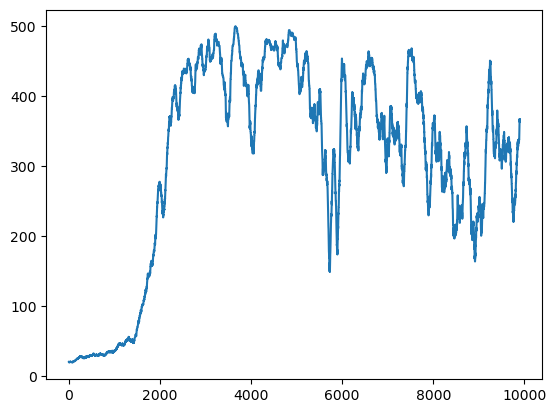

In [5]:
import matplotlib.pyplot as plt
smoothing_interval = 100 # Change for different levels of smoothing
smoothed_rewards = np.convolve(all_episode_rewards, np.ones(smoothing_interval)/smoothing_interval, 'valid')

plt.plot(smoothed_rewards)

## Visualize the policy


In [6]:
env_name = "CartPole-v1"
# Initialise the environment
env = gym.make(env_name, render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(500):
    # this is where you would insert your policy
    pred_probab, pred_score = policy(torch.tensor(observation, requires_grad=False))
    action = pred_probab.argmax()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action.item())

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

## Exercises

* The larger the total reward per episode becomes, the larger the gradient updates become (equivalent to a learning rate increase). Hence it could make sense to try to scale down the scale of the rewards the longer an episode gets. Potentially we could then scale up the learning rate.

  For example:

In [ ]:
G /= np.mean(all_episode_rewards[-100:])

* Try to do the gradient step only once per episode, not along every step in each episode.
  
* Try training and evaluating the performance for different seeds, but same hyperparameters.
  
* Try a more advanced gradient descent algorithm.
  
* Try the [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment: `gymnasium.make("LunarLander-v3")`
  
* Try to get 500 total reward per episode after as few episodes as possible. Try to get this reward after as few time steps as possible (counted in total across all episodes). Do these problem reformulations change your approach?

## Observation on NaN values

What happens if we use the predicted probabilities `probs` with `torch.log()` to compute the `scores` (log of the probabilities), instead of `LogSoftmax`? 

If you don't see a problem, try larger learning rates. NaN or inf values should be produced.

nan values are triggered if the policy during one episode is updated so much, 
that at some step within that episode the action taken has close to 0 probability under the updated policy.

There could be different solutions:
* Use $\nabla \pi / (\pi + \epsilon)$, rather than $\nabla \pi / \pi = \nabla \log(\pi)$, to prevent division by 0 or log of 0.
  
* Reduce the learning rate to prevent updating policy too much

* Do only one gradient step  at the end of the episode.
  
* We used `LogSoftmax` instead of `Log` and `Softmax`, because the gradient of `LogSoftmax` has an analytic solution without division by small values close to zero.

Illustration of the problem:

In [8]:
large_value = 90
softmax = nn.Softmax(dim=0)
input = torch.tensor([large_value, 1.0], requires_grad=True)
output = softmax(input)
prob = output[1]
logprob = torch.log(prob)
logprob.backward()

print("Input:", input)
print("Input after softmax:", output)
print("Selected probability:", prob)
print("Log probability:", logprob)
print("Input gradients of log probability:", input.grad)

# With LogSoftmax
logsoftmax = nn.LogSoftmax(dim=0)
input = torch.tensor([large_value, 1.0], requires_grad=True)
output = logsoftmax(input)
logprob = output[1]
logprob.backward()
print("\nInput:", input)
print("Input after log-softmax:", output)
print("Log probability:", logprob)
print("Input gradients of log probability:", input.grad)

Input: tensor([90.,  1.], requires_grad=True)
Input after softmax: tensor([1.0000e+00, 2.2274e-39], grad_fn=<SoftmaxBackward0>)
Selected probability: tensor(2.2274e-39, grad_fn=<SelectBackward0>)
Log probability: tensor(-89., grad_fn=<LogBackward0>)
Input gradients of log probability: tensor([-inf, nan])

Input: tensor([90.,  1.], requires_grad=True)
Input after log-softmax: tensor([  0., -89.], grad_fn=<LogSoftmaxBackward0>)
Log probability: tensor(-89., grad_fn=<SelectBackward0>)
Input gradients of log probability: tensor([-1.,  1.])
